In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random as r
import math
import keras
import cv2


from PIL import Image
from keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras.utils import np_utils, plot_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def get_files(file_dir, train_size):

    images = []   
    subfolders = []
    train_array = []
    test_array = []
    train_img_list = []
    test_img_list = []
    train_all_img = []
    test_all_img = []
 
    for dirPath, dirNames, fileNames in os.walk(file_dir):
        
        names = []
        for name in fileNames:
            names.append(os.path.join(dirPath, name))
        for name in dirNames:
            subfolders.append(os.path.join(dirPath, name))
        r.shuffle(names)
        if names != []:
            images.append(names)

    mincount = float("Inf")
    for num_folder in subfolders:
        n_img = len(os.listdir(num_folder))
        
        if n_img < mincount:
            mincount = n_img

    for i in range(len(images)):
        images[i] = images[i][0:mincount]
        train_img_list.append([])
        test_img_list.append([])
        train_num = math.ceil(len(images[i]) * train_size)
        train_img_list[i] = images[i][0:train_num]
        test_img_list[i] = images[i][train_num:]

    for i in range(len(images)):
        train_all_img.extend(train_img_list[i])

    for i in range(len(images)):
        test_all_img.extend(test_img_list[i])

    train_labels = []
    test_labels = []
    for count in range(len(subfolders)):
        train_labels = np.append(train_labels, len(train_img_list[0]) * [count])
        #print(len(train_labels))
    for count in range(len(subfolders)):
        test_labels = np.append(test_labels, len(test_img_list[0]) * [count])
            
    train_array = np.array([train_all_img, train_labels])
    train_array = train_array[:, np.random.permutation(train_array.shape[1])].T
    test_array = np.array([test_all_img, test_labels])
    test_array = test_array[:, np.random.permutation(test_array.shape[1])].T
    
    train_img = list(train_array[:, 0])
    train_labels = list(train_array[:, 1])
    train_labels = [int(float(i)) for i in train_labels]
    
    test_img = list(test_array[:, 0])
    test_labels = list(test_array[:, 1])
    test_labels = [int(float(i)) for i in test_labels]
    
    # 返回图片路径列表和对应标签列表
    return train_img, train_labels, test_img, test_labels

In [3]:
# 轉Int64資料為 tf.train.Feature 格式
def int64_feature(value):
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

# 轉Bytes資料為 tf.train.Feature 格式
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [4]:
def convert_to_TFRecord(images, labels, name):
    
    filename = 'tfrecord/all/' + name + '.tfrecords'
    
    n_samples = len(labels)
    if np.shape(images)[0] != n_samples:
        raise ValueError('Images size {} does not match label size {}'.format(images.shape[0], n_samples))

    writer = tf.python_io.TFRecordWriter(filename)       # TFRecordWriter class
    print ('Convert to TFRecords...')
    for i in np.arange(0, n_samples):
        try:
            
            image = cv2.imread(images[i], 0)                # type(image) must be array
            image_raw = image.tostring()                  # transform array to bytes
            label = int(labels[i])

            ftrs = tf.train.Features(
                    feature={'Label': int64_feature(label),
                             'image_raw': bytes_feature(image_raw)}
                   )
    
            example = tf.train.Example(features=ftrs)
            writer.write(example.SerializeToString())
        except IOError as e:
            print ('Could not read:{}'.format(images[i]))
            print ('Skip it!')
    writer.close()
    print ('Done')

In [5]:
model = Sequential()
#卷積層1
model.add(Conv2D(filters=40,
                 kernel_size=(3,3),
                 padding='same',
                 input_shape=(3,7,1), 
                 activation='relu', name = "conv_1"))
model.add(BatchNormalization(name = "bn_1"))
#卷積層2
model.add(Conv2D(filters=80,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu', name = "conv_2"))
model.add(BatchNormalization(name = "bn_2"))
#卷積層3
model.add(Conv2D(filters=160,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu', name = "conv_3"))
model.add(BatchNormalization(name = "bn_3"))

model.add(Dropout(0.25, name = "DP"))
#平坦層
model.add(Flatten(name = "Flat"))
#全連接層
model.add(Dense(320, activation='relu', name = "dense_1"))
#輸出層
model.add(Dense(5,activation='softmax', name = "dense_2"))

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 3, 7, 40)          400       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 3, 7, 40)          160       
_________________________________________________________________
conv_2 (Conv2D)              (None, 3, 7, 80)          28880     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 3, 7, 80)          320       
_________________________________________________________________
conv_3 (Conv2D)              (None, 3, 7, 160)         115360    
_________________________________________________________________
bn_3 (BatchNormalizat

In [6]:
file_dir = '7x3database'
train_img, train_labels, test_img, test_labels = get_files(file_dir, train_size=0.9)

TFRecord_list = ['train', 'test']
img_labels_list = [[train_img, train_labels], [test_img, test_labels]]

for index, TFRecord_name in enumerate(TFRecord_list):
    convert_to_TFRecord(img_labels_list[index][0], img_labels_list[index][1],
                        TFRecord_name)

Convert to TFRecords...
Done
Convert to TFRecords...
Done


In [7]:
train_images = []
for img in train_img:
    img = Image.open(img)
    img = image.img_to_array(img)
    train_images.append(img)

x_train = np.array(train_images)
y_train = np.array(train_labels)

In [8]:
test_images = []
for img in test_img:
    img = Image.open(img)
    img = image.img_to_array(img)
    test_images.append(img)

x_test = np.array(test_images)
y_test = np.array(test_labels)

In [9]:
x_train /= 255
x_test /= 255
y_train_onehot = np_utils.to_categorical(y_train)
y_test_onehot = np_utils.to_categorical(y_test)

In [10]:
#CNN training
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy']) 
train_history=model.fit(x=x_train, 
                        y=y_train_onehot,validation_split=0.1, 
                        epochs=50, batch_size=64,verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 17059 samples, validate on 1896 samples
Epoch 1/50
17059/17059 [==============================] - 16s 922us/step - loss: 0.2123 - acc: 0.9401 - val_loss: 0.1408 - val_acc: 0.9504
Epoch 2/50
17059/17059 [==============================] - 16s 935us/step - loss: 0.0767 - acc: 0.9787 - val_loss: 0.0856 - val_acc: 0.9726
Epoch 3/50
17059/17059 [==============================] - 16s 922us/step - loss: 0.0557 - acc: 0.9868 - val_loss: 0.1067 - val_acc: 0.9636
Epoch 4/50
17059/17059 [==============================] - 16s 943us/step - loss: 0.0419 - acc: 0.9883 - val_loss: 0.0373 - val_acc: 0.9879
Epoch 5/50
17059/17059 [==============================] - 16s 918us/step - loss: 0.0420 - acc: 0.9882 - val_loss: 0.0651 - val_acc: 0.9778
Epoch 6/50
17059/17059 [==============================] - 16s 918us/step - loss: 0.0337 - acc: 0.9902 - val_loss: 0.0216 - val_acc: 0.9942
Epoch 7/50
17059/17059 [==============================] - 16s 966us/s

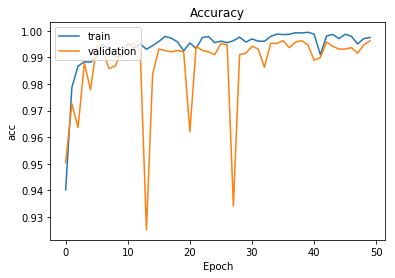

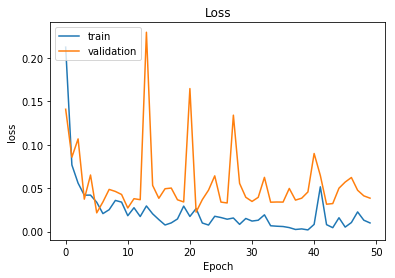

In [11]:
def show_train_history(train_history, title, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title(title)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

show_train_history(train_history, 'Accuracy', 'acc', 'val_acc')
show_train_history(train_history, 'Loss', 'loss', 'val_loss')

In [12]:
scores = model.evaluate(x_test,y_test_onehot)
print()
print('accuracy=',scores[1])

2105/2105 [==============================] - 0s 229us/step

accuracy= 0.995249406175772


In [13]:
import pandas as pd
prediction = model.predict_classes(x_test)
pd.crosstab(y_test, prediction, rownames=['label'], colnames=['predict'])

predict,0,1,2,3,4
label,,,,,
0,420,1,0,0,0
1,0,420,1,0,0
2,0,0,419,0,2
3,0,1,3,415,2
4,0,0,0,0,421


In [14]:
model.save('models/m1/pre/model.h5')

In [15]:
model.save_weights('models/m1/pre/model_weights.h5')

In [16]:
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file('models/m1/pre/model.h5')
tfmodel = converter.convert()
open ('models/m1/pre/model.tflite' , "wb") .write(tfmodel)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 22 variables.
INFO:tensorflow:Converted 22 variables to const ops.


4892808